# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation (Unsupervised)+ https://github.com/numenta/NAB (Unsupervised+Supervised)  https://www.cs.ucr.edu/~eamonn/time_series_data/ (Supervised) <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. Add un-labeled and labeled data





# What's new in version 6
1. Add labeled data
2. Apply Logistic regression
3. Apply XgBoost
4. Add a way to detect mis-labeled dots
5. Explain why complex models like NN/CNN/ATTLSTM_FCN doesn't work well
6. A combination of supervised model and un-supervised model for detecting mis-labeled samples


In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc
import json
plot_path = "plots/"



In [2]:

# Real server data (Unsupervised)

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)





['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [3]:
if False:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    




In [4]:
# labeled data:
root_path2 = "Data/Ant_labeled/"

today = []
history = []
label = []
count=0
with open(root_path2+"train_data.txt") as f:
    for line in f:
        temp = json.loads(line)
        today.append(temp["today"])
        history.append(temp["history"])
        label.append(temp["label"])
        count+=1
today = np.array(today)
history = np.array(history)
label = np.array(label).ravel()

In [7]:



# For labeled data, we use today+history+diff to check them:
X = np.c_[today,history]
#X = np.atleast_3d(X)
# X = np.dstack((today,history))
y = label





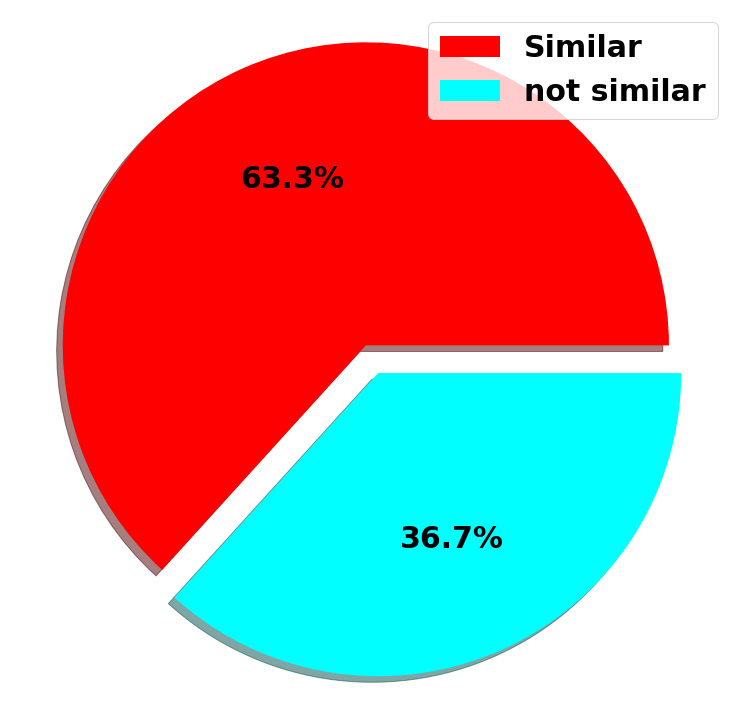

In [14]:
# Pie chart:

import matplotlib.pyplot as plt

font = {'family': 'normal','weight': 'bold','size': 30}
matplotlib.rc('font', **font) 
fig, axs = plt.subplots(1, 1)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
color_array = ["r","cyan","g"]
labels = 'Similar', 'not similar'

f = len(y[y==1])/len(y) 
sizes = [f,1-f]
explode = (0, 0.1)
axs.pie(sizes,colors=color_array, explode=explode, autopct='%1.1f%%',shadow=True)
axs.axis('equal')
axs.legend(labels)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(13,13)
save_path = plot_path + "labeled_y_pie" + ".png"

fig.savefig(save_path, dpi=150)





findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


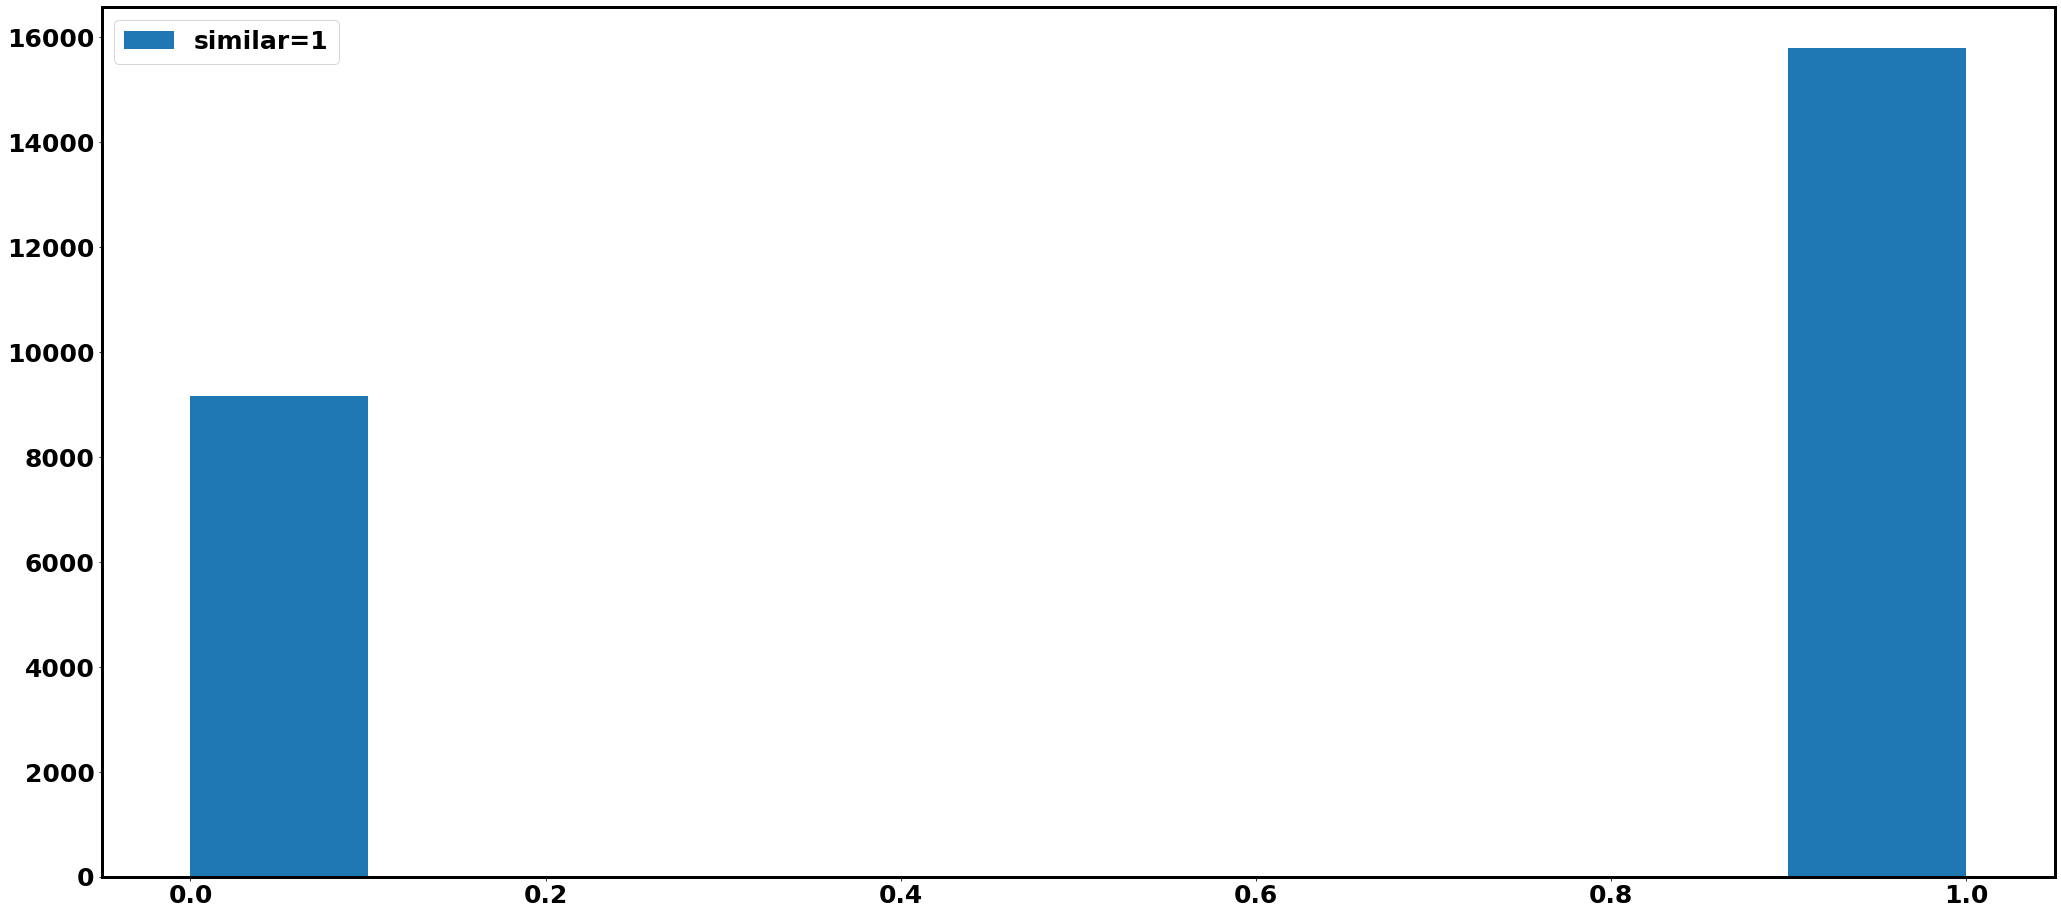

In [6]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.hist(y,label="similar=1")

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "labeled_y" + ".png"

fig.savefig(save_path, dpi=150)






findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


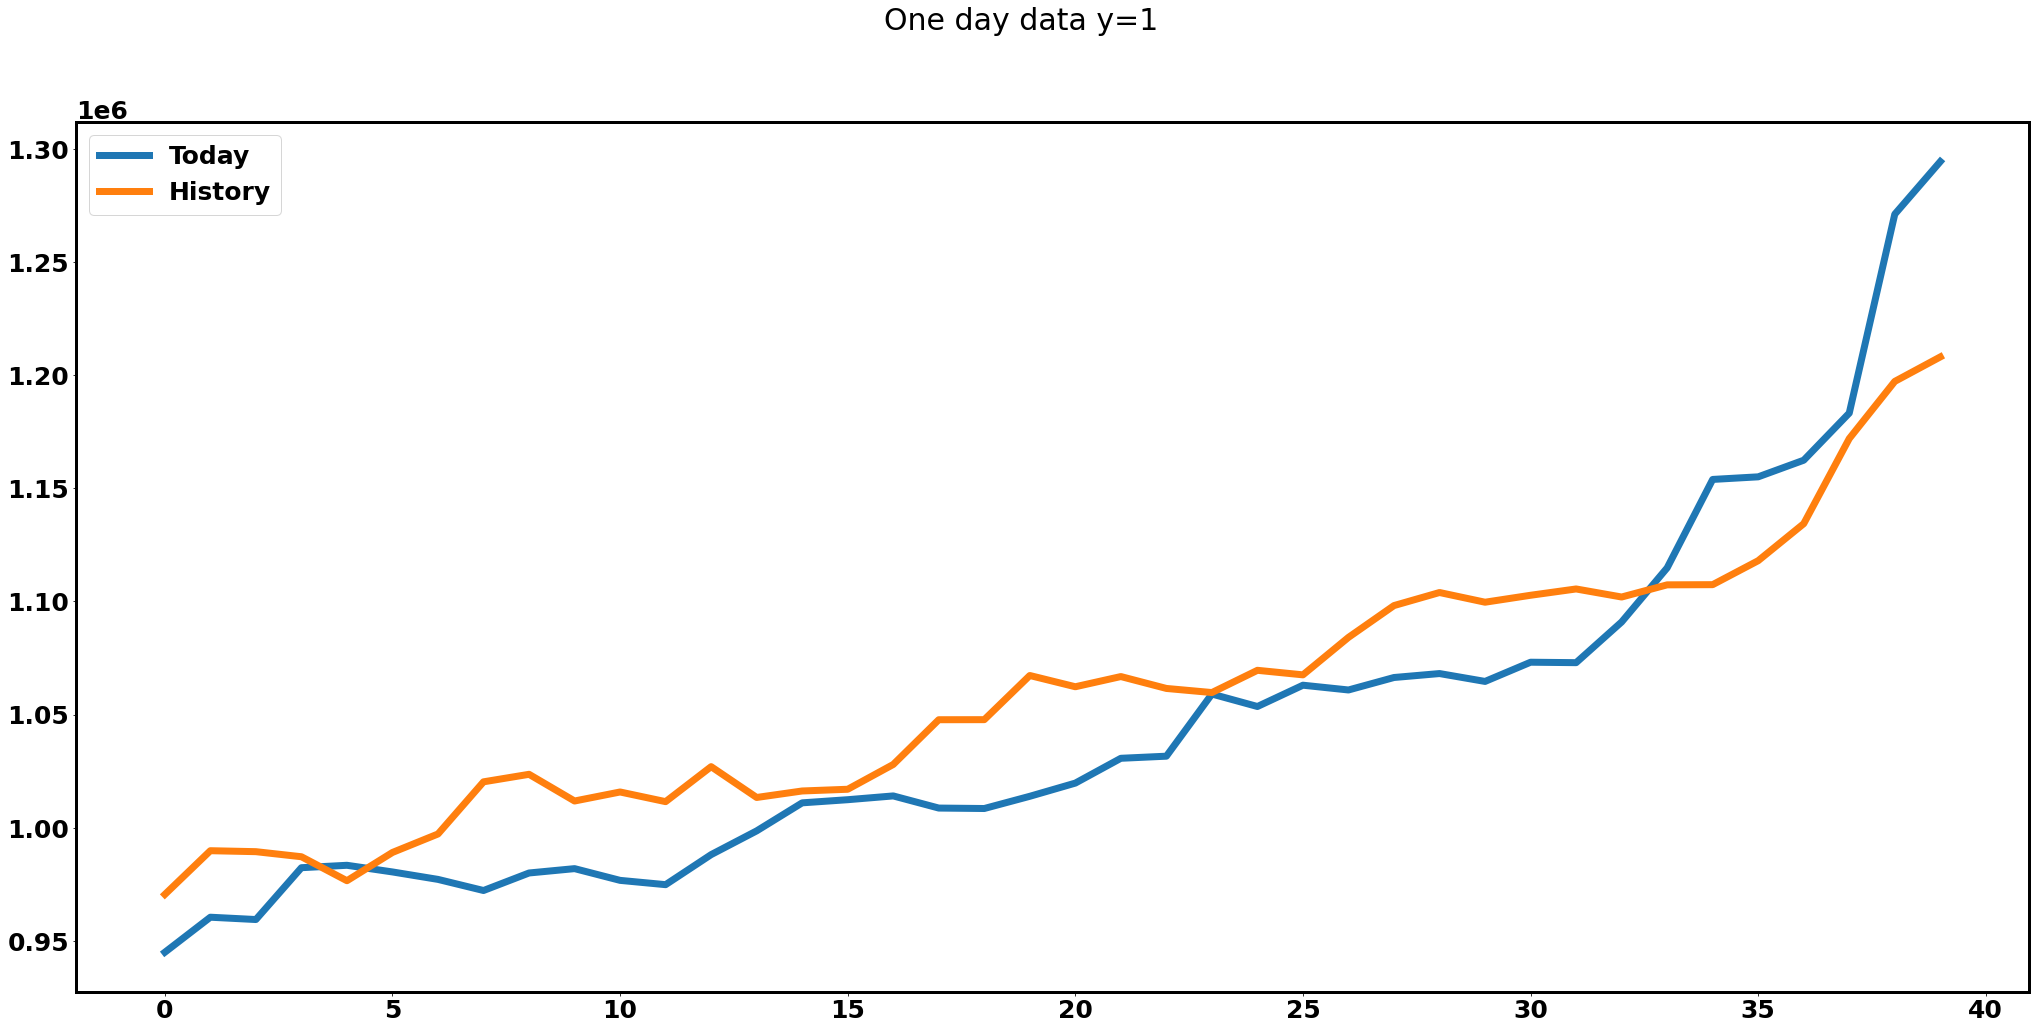

In [8]:



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(today[0,:],label = "Today",linewidth=7)
plt.plot(history[0,:],label = "History",linewidth=7)
plt.legend()
plt.suptitle("One day data y=%d"%y[0])

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "labeled_example" + ".png"

fig.savefig(save_path, dpi=150)




In [98]:
# Try xgboost

## Try log10?
#np_scaled = np.log10(X)

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)




params={}
params['booster'] = "gbtree"
params['gpu_id'] = 0
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'
"""

params['learning_rate'] = 0.01
params['max_depth'] = 12

params['reg_alpha'] = 0.15
params['reg_lamdba'] = 0.85



"""
model = XGBClassifier(n_estimators=1000,n_jobs=-1,**params)
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_bin=512, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [99]:
Y_predict_test = model.predict(X_test)
y_pred = Y_predict_test
Y_predict_test_xgboost = y_pred
mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))



Good=7086 Bad=399
Accuracy=0.9467 for testing set


In [100]:
def confusion_matrix(y_pred,y_true):
    TP = len(y_pred[(y_pred==1)&(y_true==1)])
    TN = len(y_pred[(y_pred==1)&(y_true==0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred==1)&(y_true==0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred==0)&(y_true==1)])
    
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/len(y_pred)
    
    f1_score = 2/(1/precision+1/recall)
    return TP,TN,FP,FN,recall,precision,accuracy,f1_score

temp = confusion_matrix(y_pred=y_pred,y_true=y_test)
f1 = temp[-1]
print("F1 score=%.4f"%f1)

F1 score=0.9584


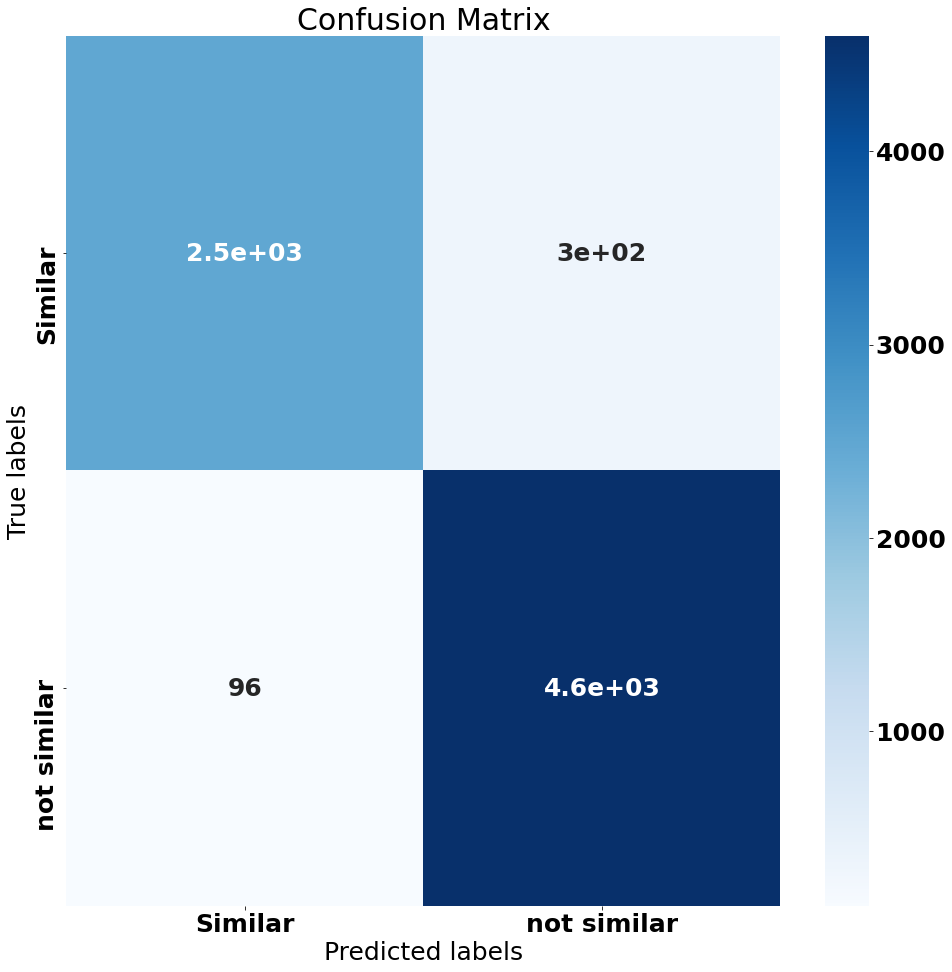

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


labels = ["Similar","not similar"] 
cm = confusion_matrix(y_test, Y_predict_test)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap=plt.cm.Blues)
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,16)
save_path = plot_path + "labeled_confusion" + ".png"

fig.savefig(save_path, dpi=150)






AUROC: 0.9818


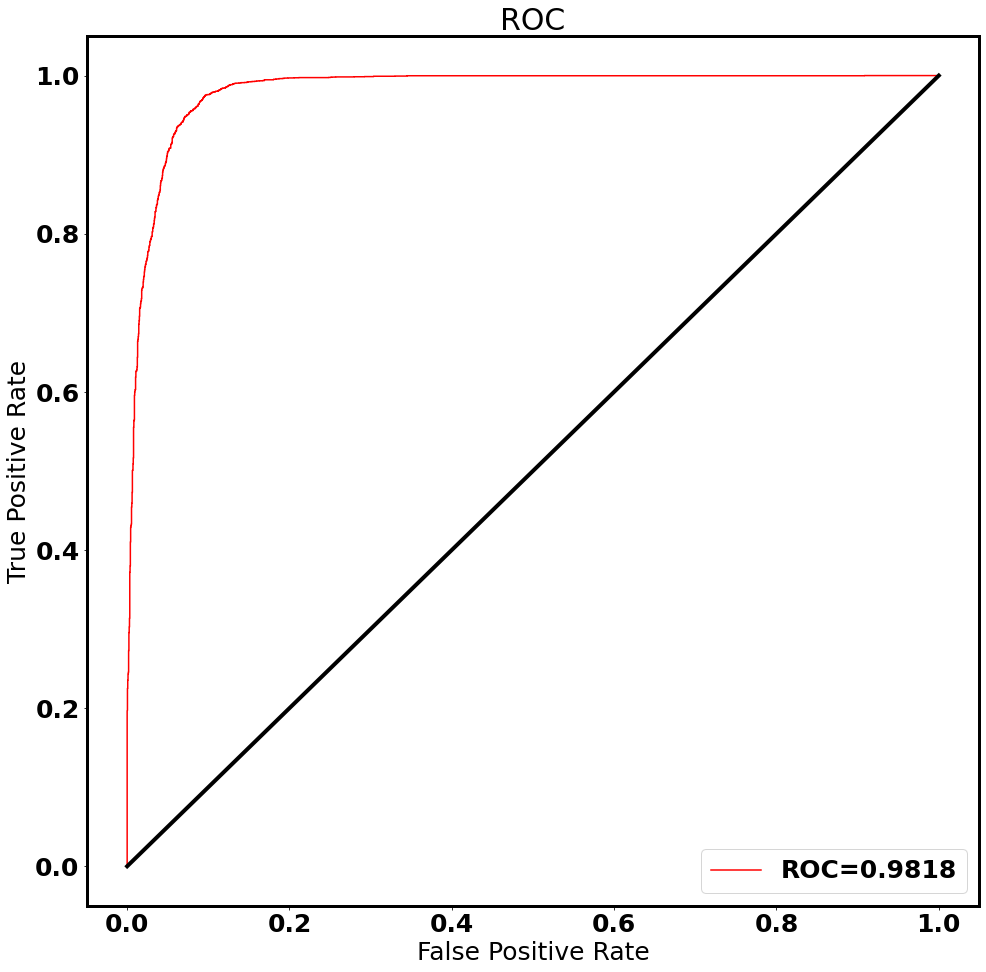

In [102]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


testy = y_test
prob = model.predict_proba(X_test)
probs = prob[:,1]



auc = roc_auc_score(testy, probs)
print('AUROC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.plot(fpr, tpr, color='r', label='ROC=%.4f'%auc)
plt.plot([0, 1], [0, 1], color='k',linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,16)
save_path = plot_path + "labeled_AUROC" + ".png"

fig.savefig(save_path, dpi=150)





## Now we reach 95% accuracy and 0.98 AUROC, which means the model has high robustness

# Try NN model since it's faster in testing:
But it doesn't work well. Since there is only 40*2 for each dimension.

In [18]:
if False:
    #### Model: need to re-think first
    from keras.models import Model
    from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
    from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout,MaxPooling1D,Flatten


    # data:
    #X = np.c_[today,history]
    #X = np.atleast_3d(X)
    X = np.dstack((today,history))
    y = label




    # Hyper parameters
    # Attention LSTM simple model
    n_epoch=40
    n_cell = 50

    index_name= 0
    rate_dropout=0.2


    checkpoint_path = "NN_classifier/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    ## Try log10?
    np_scaled = np.log10(X)

    # split train test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


    # model:

    def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
        ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
        # split into x and y two channels
        x = Masking()(ip)
        x = Flatten()(x)
        x = Dense(100)(x)
        x = Dropout(rate_dropout)(x)
        x = Dense(50, activation='relu')(x)



        out = Dense(1, activation='softmax')(x)
        print(out.shape)

        model = Model(ip, out)
        model.summary()

        # add load model code here to fine-tune

        return model

    model = generate_model(X.shape[1],X.shape[2])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()



    callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)






    # Let's do it!

    h = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)









In [19]:
# NN model doesn't perform well due to low dimension. Maybe try logistic regression?


# Logistic regression
not as good as xgboost

In [17]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


X = np.c_[today,history]
#X = np.c_[today,history,today-history]
#X = np.atleast_3d(X)
# X = np.dstack((today,history))
y = label

scaler = MinMaxScaler()
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/home/jc6933/anaconda3/envs/tf22/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:


mask_good = abs(y_pred-y_test)<0.01

print("Good=%d Bad=%d"%(len(y_pred[mask_good]),len(y_pred)-len(y_pred[mask_good])))

print("Accuracy=%.4f for testing set"%(len(y_pred[mask_good])/len(y_pred)))




Good=6599 Bad=886
Accuracy=0.8816 for testing set


In [38]:
def confusion_matrix(y_pred,y_true):
    TP = len(y_pred[(y_pred==1)&(y_true==1)])
    TN = len(y_pred[(y_pred==1)&(y_true==0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred==1)&(y_true==0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred==0)&(y_true==1)])
    
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/len(y_pred)
    
    f1_score = 2/(1/precision+1/recall)
    return TP,TN,FP,FN,recall,precision,accuracy,f1_score

temp = confusion_matrix(y_pred=y_pred,y_true=y_test)
f1 = temp[-1]
print("F1 score=%.4f"%f1)
# not very good :(
print("CLF score(Accuracy) %.4f"%clf.score(X, y))

F1 score=0.9067
CLF score(Accuracy) 0.8812


AUROC: 0.9251


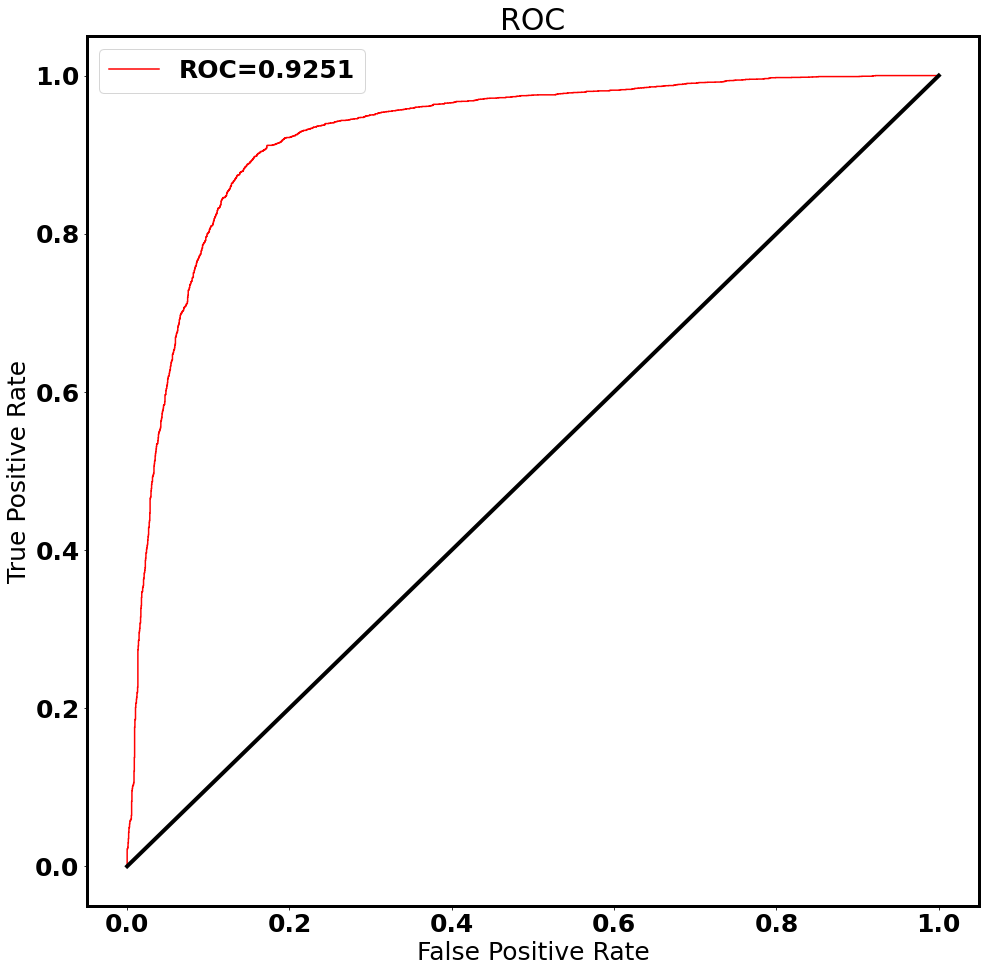

In [44]:
prob = clf.predict_proba(X_test)

testy = y_test

probs = prob[:,1]



auc = roc_auc_score(testy, probs)
print('AUROC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.plot(fpr, tpr, color='r', label='ROC=%.4f'%auc)
plt.plot([0, 1], [0, 1], color='k',linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,16)



## Since there is some mis-labeled data, we need to find them
Idea:A good way to detect mis-labeled dots: use an unsupervised model o classify them into 2 catalogs and use a supervised model to classify them. The mismatch may have a higher probability to be anomaly. Then you down-weight these dots and check whether there is an increase in your supervised model.


In [60]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = np.c_[today,history]
#X = np.atleast_3d(X)
# X = np.dstack((today,history))
y = label

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)






In [84]:
# Down to less dimensions
pca = PCA(n_components=10)

data = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, shuffle=True)



kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

X_dist = kmeans.transform(X_test)**2
test_distance = X_dist.sum(axis=1)

#Y_predict_test_xgboost = model.predict(X_test)
mask_good = Y_predict_test_xgboost==y_test

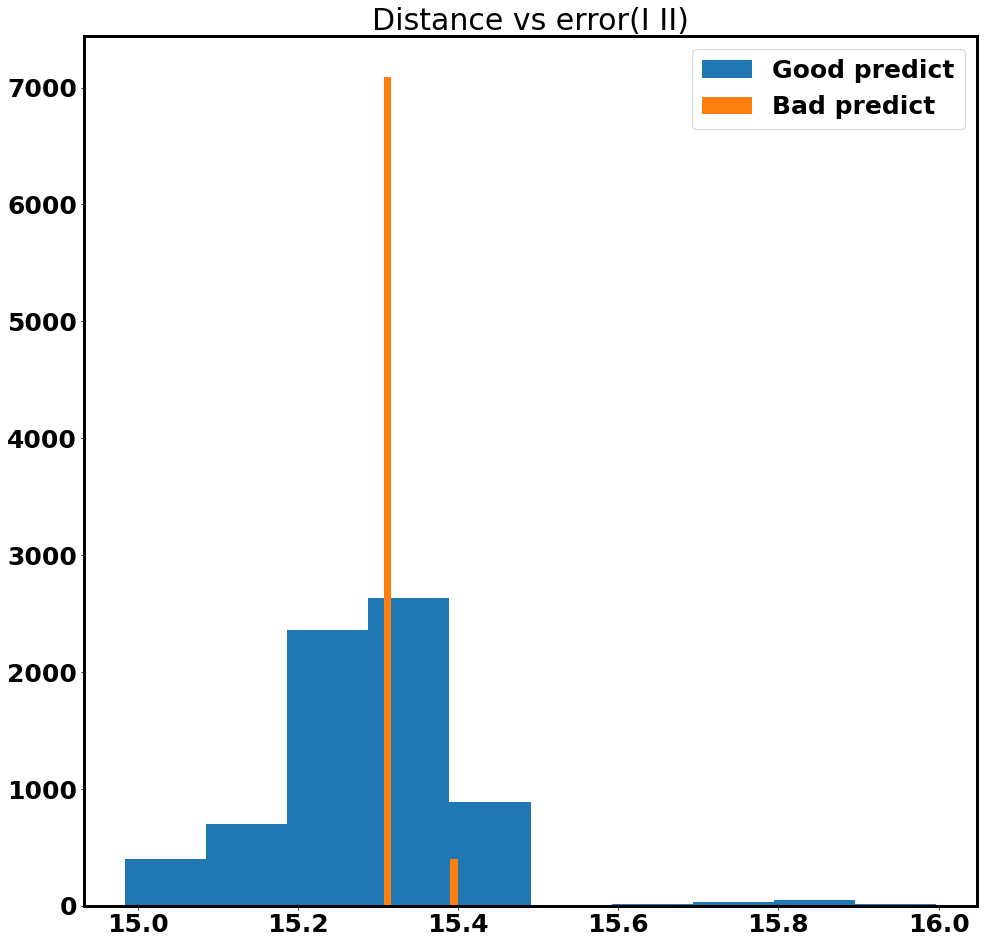

In [115]:
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



plt.hist(np.log10(test_distance[mask_good]),label="Good predict")
plt.hist(np.log10(test_distance[1-mask_good]),label="Bad predict")

plt.title('Distance vs error(I II)')
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,16)
save_path = plot_path + "labeled_hist_good_bad_predict" + ".png"

fig.savefig(save_path, dpi=150)





# We can see there is denifitely a correlation between good and bad predict
These bad predicts have a score near a specific value, which is 15.3 
Since most samples are correctly labeled, the model is learning a posterior probability for them, and thus dots that are bad must have a real special distance, which is 15.3 here.
Thus, I think we can get rid of these samples and re-train/test the model

In [136]:
# Down to less dimensions
pca = PCA(n_components=10)

data = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, shuffle=True)



kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

X_dist = kmeans.transform(data)**2
test_distance = X_dist.sum(axis=1)
test_distance_log = np.log10(test_distance)

In [145]:
# Remove part of examples near 15.3
mislabeled_ratio = 0.05
mask_mislabeled = abs(test_distance_log-15.3)>np.nanpercentile(abs(test_distance_log-15.3),100*mislabeled_ratio)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X[mask_mislabeled], y[mask_mislabeled], test_size=0.3, shuffle=True)



params={}
params['booster'] = "gbtree"
params['gpu_id'] = 0
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'

model = XGBClassifier(n_estimators=1000,n_jobs=-1,**params)
model.fit(X_train,y_train)




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_bin=512, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [147]:
Y_predict_test = model.predict(X_test)
y_pred = Y_predict_test
Y_predict_test_xgboost = y_pred
mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))




Good=6714 Bad=396
Accuracy=0.9443 for testing set


## Need further thinking :)
possible solution 1: use flip centroid until acc/auric converged <br>
possible solution 2: use MC chain to flip detected samples until acc converges <br>

## Another thing: add another dimension for the model

In [14]:
# Try xgboost with diff

X = np.c_[today,history,today-history]
# X = np.c_[today,today-history]
# X = np.c_[today,history]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)




params={}
params['booster'] = "gbtree"
params['gpu_id'] = 0
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'
"""

params['learning_rate'] = 0.01
params['max_depth'] = 12

params['reg_alpha'] = 0.15
params['reg_lamdba'] = 0.85



"""
model = XGBClassifier(n_estimators=1000,n_jobs=-1,**params)
model.fit(X_train,y_train)

Y_predict_test = model.predict(X_test)
y_pred = Y_predict_test
Y_predict_test_xgboost = y_pred
mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))







Good=7099 Bad=386
Accuracy=0.9484 for testing set
